In [1]:
import tensorflow as tf
import numpy as np
import gym

In [2]:
# number of steps in each episode
epsiode_steps = 500
# learning rate for actor
lr_a = 0.001    
# learning rate for critic
lr_c = 0.002 
# discount factor
gamma = 0.9 
# soft replacement
alpha = 0.01
# replay buffer size
memory = 10000
# batch size for training
batch_size = 32     
render = False

In [3]:
class DDPG(object):
    def __init__(self, no_of_actions, no_of_states, a_bound,):
        
        # initialize the memory with shape as no of actions, no of states and our defined memory size
        self.memory = np.zeros((memory, no_of_states * 2 + no_of_actions + 1), dtype=np.float32)
        
        # initialize pointer to point to our experience buffer
        self.pointer = 0
        
        # initialize tensorflow session
        self.sess = tf.Session()
        
        # initialize the variance for OU process for exploring policies
        self.noise_variance = 3.0
        
        self.no_of_actions, self.no_of_states, self.a_bound = no_of_actions, no_of_states, a_bound,
        
        # placeholder for current state, next state and rewards
        self.state = tf.placeholder(tf.float32, [None, no_of_states], 's')
        self.next_state = tf.placeholder(tf.float32, [None, no_of_states], 's_')
        self.reward = tf.placeholder(tf.float32, [None, 1], 'r')
        
        # build the actor network which has separate eval(primary) and target network
        with tf.variable_scope('Actor'):
            self.a = self.build_actor_network(self.state, scope='eval', trainable=True)
            a_ = self.build_actor_network(self.next_state, scope='target', trainable=False)
            
        # build the critic network which has separate eval(primary) and target network    
        with tf.variable_scope('Critic'):
            q = self.build_crtic_network(self.state, self.a, scope='eval', trainable=True)
            q_ = self.build_crtic_network(self.next_state, a_, scope='target', trainable=False)
            

        # initialize the network parameters
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # update target value
        self.soft_replace = [[tf.assign(at, (1-alpha)*at+alpha*ae), tf.assign(ct, (1-alpha)*ct+alpha*ce)]
            for at, ae, ct, ce in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]
        
        
        # compute target Q value, we know that Q(s,a) = reward + gamma * Q'(s',a')
        q_target = self.reward + gamma * q_
        
    
        # compute TD error i.e  actual - predicted values
        td_error = tf.losses.mean_squared_error(labels=(self.reward + gamma * q_), predictions=q)
        
        # train the critic network with adam optimizer
        self.ctrain = tf.train.AdamOptimizer(lr_c).minimize(td_error, name="adam-ink", var_list = self.ce_params)
        
        # compute the loss in actor network
        a_loss = - tf.reduce_mean(q)    
        
        # train the actor network with adam optimizer for minimizing the loss
        self.atrain = tf.train.AdamOptimizer(lr_a).minimize(a_loss, var_list=self.ae_params)

        # initialize summary writer to visualize our network in tensorboard
        tf.summary.FileWriter("logs", self.sess.graph)
        
        # initialize all variables
        self.sess.run(tf.global_variables_initializer())

       

    # How do we select acion in DDPG? We select action by adding noise to the action space. We use
    # Ornstein-Uhlenbeck random process for generating noise

    def choose_action(self, s):
        a = self.sess.run(self.a, {self.state: s[np.newaxis, :]})[0]
        a = np.clip(np.random.normal(a, self.noise_variance), -2, 2)
        
        return a
    
    
    # then we define the function called learn where the actual training happens,
    # here we select a minibatch of states, actions, rewards and next state from the experience buffer
    # and we train actor and critic network

    def learn(self):
        
        # soft target replacement
        self.sess.run(self.soft_replace)

        indices = np.random.choice(memory, size=batch_size)
        batch_transition = self.memory[indices, :]
        batch_states = batch_transition[:, :self.no_of_states]
        batch_actions = batch_transition[:, self.no_of_states: self.no_of_states + self.no_of_actions]
        batch_rewards = batch_transition[:, -self.no_of_states - 1: -self.no_of_states]
        batch_next_state = batch_transition[:, -self.no_of_states:]

        self.sess.run(self.atrain, {self.state: batch_states})
        self.sess.run(self.ctrain, {self.state: batch_states, self.a: batch_actions, self.reward: batch_rewards, self.next_state: batch_next_state})

    # we define a function store_transition which stores all the transition information in the buffer
    def store_transition(self, s, a, r, s_):
        trans = np.hstack((s,a,[r],s_))
        
        index = self.pointer % memory
        self.memory[index, :] = trans
        self.pointer += 1

        if self.pointer > memory:
            self.noise_variance *= 0.99995
            self.learn()
            
            
     # we define the function build_actor_network for builing our actor network       
    def build_actor_network(self, s, scope, trainable):
        # Actor DPG
        with tf.variable_scope(scope):
            l1 = tf.layers.dense(s, 30, activation = tf.nn.tanh, name = 'l1', trainable = trainable)
            a = tf.layers.dense(l1, self.no_of_actions, activation = tf.nn.tanh, name = 'a', trainable = trainable)     
            return tf.multiply(a, self.a_bound, name = "scaled_a")  


    # followed by we define the function build_crtic_network which build our critic network
    def build_crtic_network(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 30
            w1_s = tf.get_variable('w1_s', [self.no_of_states, n_l1], trainable = trainable)
            w1_a = tf.get_variable('w1_a', [self.no_of_actions, n_l1], trainable = trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable = trainable)
            net = tf.nn.tanh( tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1 )

            q = tf.layers.dense(net, 1, trainable = trainable)
            return q


In [6]:
env = gym.make("Pendulum-v0")
env = env.unwrapped
env.seed(1)
no_of_states = env.observation_space.shape[0]
no_of_actions = env.action_space.shape[0]

In [7]:
a_bound = env.action_space.high

In [8]:
ddpg = DDPG(no_of_actions, no_of_states, a_bound)
# for storing the total rewards
total_reward = []
# set the number of episodes
no_of_episodes = 1000


In [9]:
# for each episodes 
for i in range(no_of_episodes):
    # initialize the environment
    s = env.reset()
    
    # episodic reward
    ep_reward = 0
    
    for j in range(epsiode_steps):
        
        env.render()
        # select action by adding noise through OU process
        a = ddpg.choose_action(s)        
        # peform the action and move to the next state s
        s_, r, done, info = env.step(a)        
        # store the the transition to our experience buffer 
        # sample some minibatch of experience and train the network
        ddpg.store_transition(s, a, r, s_)      
        # update current state as next state
        s = s_        
        # add episodic rewards
        ep_reward += r        
        if j == epsiode_steps-1:            
            # store the total rewards
            total_reward.append(ep_reward)            
            # print rewards obtained per each episode
            print('Episode:', i, ' Reward: %i' % int(ep_reward))   
            break


Episode: 0  Reward: -4276
Episode: 1  Reward: -4373
Episode: 2  Reward: -4115
Episode: 3  Reward: -4318
Episode: 4  Reward: -4126
Episode: 5  Reward: -4235
Episode: 6  Reward: -4310
Episode: 7  Reward: -4570
Episode: 8  Reward: -3711
Episode: 9  Reward: -4305
Episode: 10  Reward: -3965
Episode: 11  Reward: -4310
Episode: 12  Reward: -4388
Episode: 13  Reward: -4014
Episode: 14  Reward: -4342
Episode: 15  Reward: -4281
Episode: 16  Reward: -4319
Episode: 17  Reward: -3542
Episode: 18  Reward: -4031
Episode: 19  Reward: -4371
Episode: 20  Reward: -4252
Episode: 21  Reward: -3627
Episode: 22  Reward: -3230
Episode: 23  Reward: -3208
Episode: 24  Reward: -3114
Episode: 25  Reward: -3208
Episode: 26  Reward: -3396
Episode: 27  Reward: -3533
Episode: 28  Reward: -3274
Episode: 29  Reward: -3529
Episode: 30  Reward: -3439
Episode: 31  Reward: -2919
Episode: 32  Reward: -3258
Episode: 33  Reward: -2640
Episode: 34  Reward: -3103
Episode: 35  Reward: -3234
Episode: 36  Reward: -2541
Episode: 37

Episode: 307  Reward: -257
Episode: 308  Reward: -481
Episode: 309  Reward: -134
Episode: 310  Reward: -2882
Episode: 311  Reward: -262
Episode: 312  Reward: -386
Episode: 313  Reward: -496
Episode: 314  Reward: -133
Episode: 315  Reward: -536
Episode: 316  Reward: -268
Episode: 317  Reward: -137
Episode: 318  Reward: -669
Episode: 319  Reward: -139
Episode: 320  Reward: -272
Episode: 321  Reward: -271
Episode: 322  Reward: -273
Episode: 323  Reward: -3745
Episode: 324  Reward: -4
Episode: 325  Reward: -268
Episode: 326  Reward: -138
Episode: 327  Reward: -3
Episode: 328  Reward: -139
Episode: 329  Reward: -135
Episode: 330  Reward: -136
Episode: 331  Reward: -273
Episode: 332  Reward: -268
Episode: 333  Reward: -138
Episode: 334  Reward: -413
Episode: 335  Reward: -280
Episode: 336  Reward: -131
Episode: 337  Reward: -4
Episode: 338  Reward: -6
Episode: 339  Reward: -275
Episode: 340  Reward: -267
Episode: 341  Reward: -267
Episode: 342  Reward: -3
Episode: 343  Reward: -136
Episode: 

Episode: 614  Reward: -128
Episode: 615  Reward: -3
Episode: 616  Reward: -135
Episode: 617  Reward: -280
Episode: 618  Reward: -4
Episode: 619  Reward: -284
Episode: 620  Reward: -125
Episode: 621  Reward: -253
Episode: 622  Reward: -381
Episode: 623  Reward: -144
Episode: 624  Reward: -402
Episode: 625  Reward: -5
Episode: 626  Reward: -133
Episode: 627  Reward: -132
Episode: 628  Reward: -291
Episode: 629  Reward: -129
Episode: 630  Reward: -265
Episode: 631  Reward: -6
Episode: 632  Reward: -136
Episode: 633  Reward: -128
Episode: 634  Reward: -377
Episode: 635  Reward: -1
Episode: 636  Reward: -141
Episode: 637  Reward: -310
Episode: 638  Reward: -127
Episode: 639  Reward: -255
Episode: 640  Reward: -127
Episode: 641  Reward: -133
Episode: 642  Reward: -278
Episode: 643  Reward: -5
Episode: 644  Reward: -134
Episode: 645  Reward: -2
Episode: 646  Reward: -6
Episode: 647  Reward: -5
Episode: 648  Reward: -364
Episode: 649  Reward: -267
Episode: 650  Reward: -125
Episode: 651  Rewar

Episode: 921  Reward: -133
Episode: 922  Reward: -140
Episode: 923  Reward: -358
Episode: 924  Reward: -252
Episode: 925  Reward: -136
Episode: 926  Reward: -398
Episode: 927  Reward: -9
Episode: 928  Reward: -129
Episode: 929  Reward: -129
Episode: 930  Reward: -129
Episode: 931  Reward: -128
Episode: 932  Reward: -304
Episode: 933  Reward: -262
Episode: 934  Reward: -134
Episode: 935  Reward: -126
Episode: 936  Reward: -296
Episode: 937  Reward: -270
Episode: 938  Reward: -270
Episode: 939  Reward: -130
Episode: 940  Reward: -127
Episode: 941  Reward: -134
Episode: 942  Reward: -287
Episode: 943  Reward: -127
Episode: 944  Reward: -244
Episode: 945  Reward: -249
Episode: 946  Reward: -353
Episode: 947  Reward: -130
Episode: 948  Reward: -1173
Episode: 949  Reward: -259
Episode: 950  Reward: -664
Episode: 951  Reward: -1883
Episode: 952  Reward: -326
Episode: 953  Reward: -669
Episode: 954  Reward: -261
Episode: 955  Reward: -133
Episode: 956  Reward: -9
Episode: 957  Reward: -378
Epi

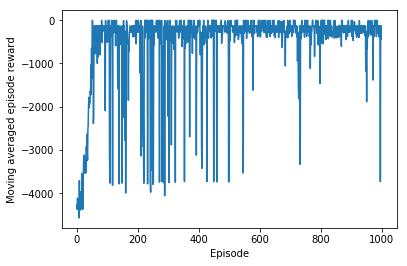

In [11]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(total_reward)), total_reward)
plt.xlabel('Episode');plt.ylabel('Moving averaged episode reward');plt.show()